In [215]:
from qclab.models.spin_holstein_model import SpinHolsteinLatticeModel

input_params = dict(temp = 1, j = .1, w = 5, g = .1, m = 1, num_states = 8, open = False)
model = SpinHolsteinLatticeModel(input_params = input_params)

model.batch_size = 100
model.tmax = 10
model.dt_output = 0.1
model.dt = 0.01
model.k_F = 0.25

import numpy as np


def fft_mat(num_states):
    out_mat = np.zeros((num_states, num_states), dtype=complex)
    k_axis = np.zeros((num_states))
    for n in np.arange(0, num_states):
        for k in np.arange(-int(num_states/2), int(num_states/2)):
            out_mat[n, k+int(num_states/2)] = np.sqrt(1/num_states)*np.exp(1.0j*2*np.pi*n*k/num_states)
            k_axis[k+int(num_states/2)] = (k/num_states)
    return out_mat, k_axis

#model.wf_db_MB = np.zeros((model.num_states, model.num_particles), dtype=complex)
#model.wf_db_MB[:, :int(model.num_particles/2)]  = np.identity(model.num_states)[:, :int(model.num_particles/2)] + 0.0j
#model.wf_db_MB[:, int(model.num_particles/2):]  = np.identity(model.num_states)[:, int(model.num_states/2):int(model.num_states/2)+int(model.num_particles/2)] + 0.0j


fft_trans, k_axis = fft_mat(int(model.num_states/2))
print(k_axis)
occupied_states = np.where(np.abs(k_axis) <= model.k_F)[0]
print(occupied_states)
model.num_particles = 2*len(occupied_states)
print(model.num_particles)
spin_fft_trans = np.zeros((model.num_states, model.num_states), dtype=complex)
spin_fft_trans[:int(model.num_states/2),:][:,:int(model.num_states/2)] = fft_trans 
spin_fft_trans[int(model.num_states/2):,:][:,int(model.num_states/2):] = fft_trans
model.wf_db_MB = np.zeros((model.num_states, model.num_particles), dtype=complex)
model.wf_db_MB[:,:int(model.num_particles/2)] = spin_fft_trans[:,occupied_states]
model.wf_db_MB[:,int(model.num_particles/2):] = spin_fft_trans[:,occupied_states+int(model.num_states/2)]


seeds = np.arange(1*model.batch_size, dtype=int)

from qclab.recipes import ManyBodyMeanFieldDynamicsRecipe
recipe = ManyBodyMeanFieldDynamicsRecipe(model)
def get_wf_db(state):
    state.wf_db = np.sum(state.wf_db_MB, axis=(0,1))
    return state
recipe.output.append(get_wf_db)
recipe.output_names.append('wf_db')

from qclab.drivers.serial_driver import dynamics_serial

data = dynamics_serial(recipe=recipe, model = model, seeds = seeds, ncpus = 1, data = None)

[-0.5  -0.25  0.    0.25]
[1 2 3]
6


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:24<00:00, 24.44s/it]


(101, 8, 6)
[ 1.          1.14109163  1.66915925  2.92437988  5.38779061  8.83414305
 11.13515877 10.09576122  6.84763863  3.92567602  2.21140499  1.39283365
  1.06982401  1.05101661  1.33694077  2.1293514   3.86403868  6.8780607
 10.19150795 11.19295047  8.92999447  5.60547542  3.18220634  1.88414808
  1.29630389  1.10746445  1.21265191  1.69373205  2.85254534  5.15213197
  8.51798803 11.13181173 10.66280561  7.68005755  4.63938754  2.7085387
  1.73049935  1.31644911  1.25050921  1.50814774  2.25759912  3.88021209
  6.70380871  9.98189094 11.39949938  9.68410287  6.52563087  3.94894082
  2.44596703  1.71365435  1.44408394  1.51057003  1.96641442  3.05982625
  5.17100463  8.26107689 10.88428245 10.93781571  8.48721699  5.56891199
  3.49792987  2.34756839  1.81247803  1.67879849  1.90050208  2.60202467
  4.07265223  6.54438219  9.44699938 10.98884196  9.9263103   7.30012334
  4.84538396  3.2431497   2.38021856  2.01403529  2.01914762  2.4191603
  3.38730252  5.1728686   7.70812209  9.95

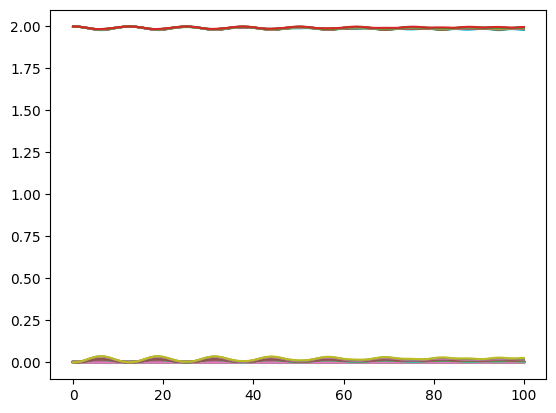

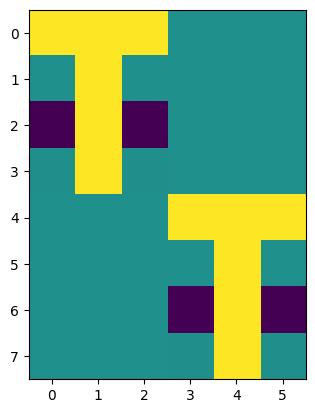

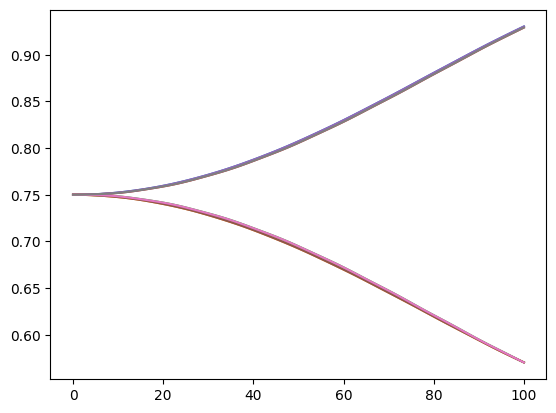

In [220]:
ntraj = len(data.seed_list)
rdm1 = data.data_dic['rdm1']/ntraj
rdm2 = data.data_dic['rdm2']/ntraj
wf_db = data.data_dic['wf_db']/ntraj
print(np.shape(wf_db))
wf_db = wf_db / np.sqrt(np.abs(np.linalg.det(np.einsum('tin,tim->tnm',np.conjugate(wf_db), wf_db,optimize='greedy')))**2)[:,np.newaxis,np.newaxis]
print(np.abs(np.linalg.det(np.einsum('tin,tim->tnm',np.conjugate(wf_db), wf_db,optimize='greedy')))**2)
rdm2 = -rdm2.reshape(len(rdm2),model.num_states**2, model.num_states**2)
rdm2_evals, _ = np.linalg.eigh(rdm2)
#print(rdm2_evals)
pops = np.real(np.einsum('tii->ti', rdm1, optimize='greedy'))
print(rdm2_evals[:,-1])
import matplotlib.pyplot as plt
plt.plot(rdm2_evals)
plt.show()


plt.imshow(np.real(model.wf_db_MB))
plt.show()

plt.plot(pops)
plt.show()

In [190]:
rdm1_evals, rdm1_evecs = np.linalg.eigh(rdm1)
print(rdm1_evals)

[[-6.78045338e-16 -7.42069351e-17 -3.71829994e-17 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [-6.57432079e-16 -6.12907101e-16 -2.40574829e-16 ...  1.00000001e+00
   1.00000001e+00  1.00000001e+00]
 [-1.12725420e-15 -4.50548041e-16 -2.60716270e-16 ...  1.00000002e+00
   1.00000002e+00  1.00000002e+00]
 ...
 [-9.76667584e-16 -6.38079842e-16 -1.98370971e-16 ...  1.00000481e+00
   1.00000492e+00  1.00000492e+00]
 [-2.82974653e-16 -2.73846737e-16 -1.46525078e-16 ...  1.00000484e+00
   1.00000495e+00  1.00000495e+00]
 [-6.94539089e-16 -4.97635460e-16 -1.37445588e-16 ...  1.00000485e+00
   1.00000496e+00  1.00000496e+00]]


In [191]:

evals, evecs = np.linalg.eigh(-rdm2.reshape(len(rdm2), model.num_states**2, model.num_states**2))

plt.plot(evals)
plt.show()
print(np.max(evals))

KeyboardInterrupt: 

In [128]:

evals, evecs = np.linalg.eigh(-rdm2[-1].reshape(model.num_states**2, model.num_states**2))
print(evals)
print(np.sum(evals))

[-2.18382077e-15 -1.93899987e-15 -1.91910438e-15 -1.86732258e-15
 -1.80561784e-15 -1.66429982e-15 -1.29376173e-15 -1.28194580e-15
 -1.26988485e-15 -1.19051405e-15 -1.13890648e-15 -1.05811365e-15
 -1.04339007e-15 -9.63212967e-16 -9.46827531e-16 -9.31603890e-16
 -9.01608457e-16 -8.40748575e-16 -8.30171204e-16 -8.04528392e-16
 -7.85219436e-16 -7.71867125e-16 -7.70761297e-16 -7.22908668e-16
 -6.97613696e-16 -6.89644053e-16 -6.67952829e-16 -6.67450499e-16
 -6.52950290e-16 -6.20000299e-16 -5.96719575e-16 -5.80333659e-16
 -5.73147153e-16 -5.25955516e-16 -5.20247442e-16 -5.15633921e-16
 -4.92068752e-16 -4.82537085e-16 -4.77952482e-16 -4.55284189e-16
 -4.54393903e-16 -4.52261336e-16 -4.31539727e-16 -4.16562842e-16
 -4.11097382e-16 -3.88255178e-16 -3.64932899e-16 -3.33338505e-16
 -3.32672266e-16 -3.26151302e-16 -3.22223516e-16 -3.21517475e-16
 -3.12335968e-16 -3.08497595e-16 -3.04002281e-16 -2.97202659e-16
 -2.83732830e-16 -2.74787397e-16 -2.55046006e-16 -2.51947076e-16
 -2.44944267e-16 -2.40211

[-2.18382077e-15 -1.93899987e-15 -1.91910438e-15 -1.86732258e-15
 -1.80561784e-15 -1.66429982e-15 -1.29376173e-15 -1.28194580e-15
 -1.26988485e-15 -1.19051405e-15 -1.13890648e-15 -1.05811365e-15
 -1.04339007e-15 -9.63212967e-16 -9.46827531e-16 -9.31603890e-16
 -9.01608457e-16 -8.40748575e-16 -8.30171204e-16 -8.04528392e-16
 -7.85219436e-16 -7.71867125e-16 -7.70761297e-16 -7.22908668e-16
 -6.97613696e-16 -6.89644053e-16 -6.67952829e-16 -6.67450499e-16
 -6.52950290e-16 -6.20000299e-16 -5.96719575e-16 -5.80333659e-16
 -5.73147153e-16 -5.25955516e-16 -5.20247442e-16 -5.15633921e-16
 -4.92068752e-16 -4.82537085e-16 -4.77952482e-16 -4.55284189e-16
 -4.54393903e-16 -4.52261336e-16 -4.31539727e-16 -4.16562842e-16
 -4.11097382e-16 -3.88255178e-16 -3.64932899e-16 -3.33338505e-16
 -3.32672266e-16 -3.26151302e-16 -3.22223516e-16 -3.21517475e-16
 -3.12335968e-16 -3.08497595e-16 -3.04002281e-16 -2.97202659e-16
 -2.83732830e-16 -2.74787397e-16 -2.55046006e-16 -2.51947076e-16
 -2.44944267e-16 -2.40211

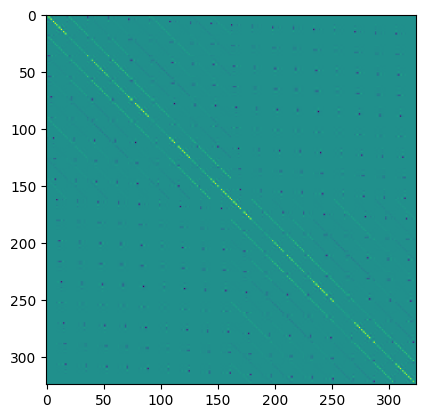

In [129]:
out = np.zeros((model.num_states**2, model.num_states**2), dtype=complex)
for i in range(model.num_states):
    for j in range(model.num_states):
        for l in range(model.num_states):
            for k in range(model.num_states):
                out[i*model.num_states + j, l*model.num_states + k] = rdm2[-1][i,j,k,l]

evals, evecs = np.linalg.eigh(out)
print(evals)
print(np.sum(evals))
plt.imshow(np.real(out))
plt.show()

In [183]:

from sympy.utilities.iterables import multiset_permutations
from tqdm import tqdm

def S(Np, Ns):  # generate occupation numbers for basis
    S0 = np.zeros(Ns, dtype=int) # this is the occupation number basis
    S0[:Np] = 1 # fill it with Np ones
    return np.array(list(multiset_permutations(S0)))# generate all possible permutations of this occupation number basis
def q_fac(i_N, j):
    return (-1)**(np.sum(i_N[:j]))

Np = 4
Ns = 4

basis = S(Np,2*Ns) #verify to yourself that this function works as expected
spin_polarization = (np.sum(basis[:,:Ns],axis=1) - np.sum(basis[:,Ns:],axis=1))/2
#basis = basis[np.argsort(spin_polarization)]
basis_S0 = basis[np.abs(spin_polarization)<1e-6]
#print(basis)
#print(basis_S0)

basis_2 = S(2,2*Ns)
spin_polarization_2 = (np.sum(basis_2[:,:Ns],axis=1) - np.sum(basis_2[:,Ns:],axis=1))/2
basis_2_S0 = basis_2[np.abs(spin_polarization_2)<1e-6]



def sd_to_wf(psi_sd):
    out = np.zeros((*np.shape(psi_sd)[:-2], len(basis_S0)), dtype=complex)
    for n in range(len(basis_S0)):
        psi_mat = psi_sd[...,np.where(basis_S0[n]==1)[0],:]
        out[...,n] = np.linalg.det(psi_mat)
    return out

def update_dm_db_MB(state):
    psi = sd_to_wf(state.wf_db_MB)
    state.dm_db_MB = np.einsum('tbi,tbj->ij',psi, np.conj(psi), optimize='greedy')
    return state


from qclab.models.spin_holstein_model import SpinHolsteinLatticeModel

input_params = dict(temp = 0.001, j = .1, w = 5, g = .1, m = 1, num_states = 2*Ns, open = False)
model = SpinHolsteinLatticeModel(input_params = input_params)

model.batch_size = 100
model.tmax = 10
model.dt_output = 0.1
model.dt = 0.01
model.num_particles = Np

import numpy as np


model.wf_db_MB = np.zeros((model.num_states, model.num_particles), dtype=complex)
model.wf_db_MB[:, :int(model.num_particles/2)]  = np.identity(model.num_states)[:, :int(model.num_particles/2)] + 0.0j
model.wf_db_MB[:, int(model.num_particles/2):]  = np.identity(model.num_states)[:, int(model.num_states/2):int(model.num_states/2)+int(model.num_particles/2)] + 0.0j


seeds = np.arange(10*model.batch_size, dtype=int)

from qclab.recipes import ManyBodyMeanFieldDynamicsRecipe
recipe = ManyBodyMeanFieldDynamicsRecipe(model)

recipe.output.append(update_dm_db_MB)
recipe.output_names.append('dm_db_MB')

from qclab.drivers.serial_driver import dynamics_serial

data = dynamics_serial(recipe=recipe, model = model, seeds = seeds, ncpus = 1, data = None)


100%|██████████| 10/10 [02:23<00:00, 14.33s/it]


In [184]:
ntraj = len(data.seed_list)
rdm1 = data.data_dic['rdm1']/ntraj
rdm2 = data.data_dic['rdm2'].reshape(len(rdm1), model.num_states**2, model.num_states**2)/ntraj
dm = data.data_dic['dm_db_MB']/ntraj

evals, evecs = np.linalg.eigh(dm)
print(evals)
print(np.sum(evals, axis=-1))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-3.65520405e-16 -3.33069946e-16 -2.75030914e-16 ...  1.16892282e-15
   9.29149531e-11  1.00000000e+00]
 [-2.95981719e-16 -2.46804232e-16 -2.03781854e-16 ...  7.43989767e-14
   1.48939549e-09  9.99999999e-01]
 ...
 [-2.50654804e-16 -2.23149390e-16 -1.64689999e-16 ...  1.44495841e-06
   3.26656019e-06  9.99994152e-01]
 [-2.19628439e-16 -1.74868502e-16 -1.69525504e-16 ...  1.56128607e-06
   3.42457430e-06  9.99993796e-01]
 [-2.28249413e-16 -2.17859209e-16 -2.07196664e-16 ...  1.64141802e-06
   3.47496650e-06  9.99993638e-01]]
[1.         1.         1.         1.         1.         1.
 1.         1.         1.00000001 1.00000001 1.00000001 1.00000001
 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001
 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001 1.00000001
 1.00000001 1.00000001 1.00000002 1.00000002 1.00000002 1.00000002
 1.00000002 1.00000002 1.00000002 1.0

In [185]:
import scipy
def gen_rho2(i,j,k,l,rho2):
    if i == j or k == l:
        #print("AAA")
        return 0
    ran = np.arange(len(basis_S0)).astype(int)
    kl_occ = ran[(basis_S0[:,k] == 1) * (basis_S0[:,l] == 1)]
    kl_sigs = np.zeros((len(kl_occ)))
    kl_conn = np.zeros((len(kl_occ), 2*Ns), dtype=int)
    ind = 0
    for n in kl_occ:
        basis_n = np.copy(basis_S0[n])
        kl_sigs[ind] = q_fac(basis_n,l)
        l_basis_n = np.copy(basis_n)
        l_basis_n[l] = 0
        kl_sigs[ind] *= q_fac(l_basis_n, k)
        kl_basis_n = np.copy(l_basis_n)
        kl_basis_n[k] = 0
        kl_conn[ind] = kl_basis_n
        ind += 1
    ij_occ = ran[(basis_S0[:,i] == 1) * (basis_S0[:,j] == 1)]
    ij_sigs = np.zeros((len(ij_occ)))
    ij_conn = np.zeros((len(ij_occ), 2*Ns), dtype=int)
    ind = 0
    for n in ij_occ:
        basis_n = np.copy(basis_S0[n])
        ij_sigs[ind] = q_fac(basis_n, i)
        i_basis_n = np.copy(basis_n)
        i_basis_n[i] = 0
        ij_sigs[ind] *= q_fac(i_basis_n, j)
        ij_basis_n = np.copy(i_basis_n)
        ij_basis_n[j] = 0
        ij_conn[ind] = ij_basis_n
        ind += 1
    row = np.array([], dtype=int)
    col = np.array([], dtype=int)
    mel = np.array([], dtype=complex)
    #print(ij_occ, kl_occ)
    if len(ij_occ)==0 or len(kl_occ) == 0:
        #print('AAA',i,j,k,l,basis_S0[ij_occ], basis_S0[kl_occ], ij_conn, kl_conn)
        return 0
    #print(i,j,k,l,ij_occ, kl_occ, ij_sigs, kl_sigs)
    for a in range(len(ij_occ)):
        ij_val = ij_conn[a]
        conn_pos = np.where(np.sum(np.abs(kl_conn - ij_val[np.newaxis,:]),axis=1) < 1e-4)[0]
        #print(i,j,k,l,basis_S0[ij_occ], basis_S0[kl_occ], ij_conn, kl_conn, conn_pos)
        row = np.append(row, kl_occ[conn_pos])
        col = np.append(col, ij_occ[a] + np.zeros(len(conn_pos), dtype=int))
        mel = np.append(mel, kl_sigs[conn_pos]*ij_sigs[a])
    mat = scipy.sparse.coo_array((mel, (row, col)), shape=(len(basis_S0), len(basis_S0))).toarray()
    #print(i,j,k,l)
    #plt.imshow(np.real(mat))
    #plt.show()
    return np.trace(mat.dot(rho2))

def get_2rdm(rho_el):
    rdm2 = np.zeros((len(basis_2),len(basis_2)), dtype=complex)
    for n in tqdm(range(len(basis_2))):
        for m in range(len(basis_2)):
            basis_n = basis_2[n]
            basis_m = basis_2[m]
            n_ij = np.where(basis_n == 1)[0]
            m_kl = np.where(basis_m == 1)[0]
            rdm2[n,m] = gen_rho2(n_ij[0],n_ij[1],m_kl[1],m_kl[0],rho_el) - gen_rho2(n_ij[0],n_ij[1],m_kl[0],m_kl[1], rho_el)
    #rdm2 = np.zeros((2*Ns*2*Ns,2*Ns*2*Ns), dtype=complex)
    #hp_basis = np.zeros((2*Ns*2*Ns,2), dtype=int)
    #for i in tqdm(range(2*Ns)):
    #    for j in range(2*Ns):
    #        hp_basis[i+j*2*Ns] = np.array([i,j])
    #        for k in range(2*Ns):
    #            for l in range(2*Ns):
    #                rdm2[i+j*2*Ns,k+l*2*Ns] += gen_rho2(i,j,l,k,rho_el)
    return rdm2#, hp_basis



In [186]:
rdm21 = get_2rdm(dm[-1])

evals, evecs = np.linalg.eigh(rdm21)
print(evals)
print(np.sum(evals))
evals, evecs = np.linalg.eigh(-rdm2[-1])
print(evals)
print(np.sum(evals))
print(len(evals))

100%|██████████| 28/28 [00:00<00:00, 48.09it/s]

[2.05121812e-12 2.05134039e-12 2.05134825e-12 2.72847437e-12
 7.04020235e-12 1.92464710e-11 1.49392107e-09 1.49392109e-09
 1.49392114e-09 1.29738184e-06 1.29738184e-06 1.29738184e-06
 1.64142600e-06 1.64142600e-06 1.64142600e-06 1.90565794e-06
 3.27566363e-06 3.47499179e-06 3.47499179e-06 3.47499179e-06
 6.00602095e-06 8.05847619e-06 1.99999079e+00 1.99999369e+00
 1.99999369e+00 1.99999369e+00 1.99999369e+00 1.99999659e+00]
12.000000635729263
[-8.29217086e-16 -6.34405539e-16 -5.26972656e-16 -3.72051559e-16
 -2.92219935e-16 -2.78223891e-16 -2.63401376e-16 -2.26640884e-16
 -2.17543467e-16 -1.47379292e-16 -1.33862310e-16 -9.01616118e-17
 -7.90888887e-17 -5.96504983e-17 -3.74232378e-17 -2.52265991e-17
 -8.05303096e-18 -3.86177618e-18 -1.38343144e-18 -2.96918059e-26
 -0.00000000e+00  1.51531780e-21  3.13980556e-20  8.25000375e-18
  1.92502862e-17  3.95862640e-17  5.42437111e-17  8.42266547e-17
  9.74921566e-17  1.27655273e-16  2.35066332e-16  2.62187565e-16
  3.97213233e-16  5.78906804e-16 

In [175]:
print(np.shape(rdm2))

(101, 64, 64)
